# Get the Data and Install Mediapipe

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [3]:
!unzip gdrive/My\ Drive/AFLW2000-3D.zip

Archive:  gdrive/My Drive/AFLW2000-3D.zip
   creating: AFLW2000/
   creating: AFLW2000/Code/
  inflating: AFLW2000/Code/DrawSolidHead.m  
  inflating: AFLW2000/Code/DrawTextureHead.m  
  inflating: AFLW2000/Code/main_show_without_BFM.m  
  inflating: AFLW2000/Code/main_show_with_BFM.m  
   creating: AFLW2000/Code/Mex/
  inflating: AFLW2000/Code/Mex/compile.m  
  inflating: AFLW2000/Code/Mex/Tnorm_Vnorm.h  
  inflating: AFLW2000/Code/Mex/Tnorm_VnormC.cpp  
  inflating: AFLW2000/Code/Mex/Tnorm_VnormC.mexw64  
   creating: AFLW2000/Code/ModelGeneration/
  inflating: AFLW2000/Code/ModelGeneration/ModelGenerate.m  
  inflating: AFLW2000/Code/ModelGeneration/model_info.mat  
  inflating: AFLW2000/Code/Model_Exp.mat  
  inflating: AFLW2000/Code/Model_Shape_Sim.mat  
  inflating: AFLW2000/Code/NormDirection.m  
  inflating: AFLW2000/Code/readme.txt  
  inflating: AFLW2000/Code/RotationMatrix.m  
  inflating: AFLW2000/Code/Tnorm_VnormC.mexw64  
  inflating: AFLW2000/image00002.jpg  
  inflating

In [4]:
!pip install mediapipe

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.0/33.0 MB 39.1 MB/s eta 0:00:00


# Import important Liberaries


In [24]:
import numpy as np
import os,cv2,math,glob,random
import scipy.io as sio
from math import cos, sin
import pandas as pd
from pathlib import Path
import pandas as pd
import mediapipe as mp
import warnings
warnings.filterwarnings('ignore')
from google.colab.patches import cv2_imshow

In [25]:
def draw_axis(img, pitch,yaw,roll, tdx=None, tdy=None, size = 100):
    yaw = -yaw
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),4)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),4)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),3)

    return img

# **Exetract Featuers and Labels**



In [26]:
folder_dir = "/content/AFLW2000"
faceModule = mp.solutions.face_mesh
x_data = []
y_data=[]
pathes =[]
label_data=[]
x123 =[]
# loading image and its correspinding mat file
with faceModule.FaceMesh(static_image_mode=True) as faces:
    #mage00002.jpg
    # loading the image  ‪
    for images in os.listdir(folder_dir):
        
    # check if the image ends with png or jpg or jpeg
        if (images.endswith(".png") or images.endswith(".jpg") or images.endswith(".jpeg")):
            image =cv2.imread(folder_dir+"/"+ images)
            results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            if results.multi_face_landmarks != None:
                mat_data  =  sio.loadmat(folder_dir+"/"+ images[:-3]+'mat')
                label_data.append(mat_data['Pose_Para'][0][:3]) 
                for face in results.multi_face_landmarks:
                    columns_x=[]        
                    columns_y=[]
                    for idx ,  landmark in  enumerate(face.landmark):
                        if idx ==1:
                          x123.append(landmark.x)
                          x123.append(landmark.y)
                        x = landmark.x
                        y = landmark.y
                        columns_x.append(x)
                        columns_y.append(y)
                        shape = image.shape 
                    x_data.append(columns_x)
                    y_data.append(columns_y)
                        
                
features_x = np.array(x_data)
features_y = np.array(y_data)
# differencing the points from point 0
x_center = features_x - features_x[:,0].reshape(-1,1)
y_center = features_y - features_y[:,0].reshape(-1,1)
features_data = np.hstack([x_center,y_center])

label_data = np.array(label_data)           



In [27]:
features_data.shape

(1853, 936)

In [28]:
y_pitch= label_data[:,0]
y_yaw= label_data[:,1]
y_roll= label_data[:,2]
X = features_data


In [29]:
print(y_pitch.shape)
print(y_roll.shape)
print(y_yaw.shape)

(1853,)
(1853,)
(1853,)


In [30]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Lasso,Ridge
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [31]:
from sklearn.model_selection import train_test_split
x_train_pitch, x_valid_pitch, y_train_pitch, y_valid_pitch = train_test_split(X, y_pitch, test_size=0.2, random_state=42)
x_train_yaw, x_valid_yaw, y_train_yaw, y_valid_yaw= train_test_split(X, y_yaw, test_size=0.2, random_state=42)
x_train_roll ,x_valid_roll, y_train_roll, y_valid_roll = train_test_split(X, y_roll, test_size=0.2, random_state=42)

In [32]:
svr_pitch =SVR()
svr_pitch.fit(x_train_pitch  , y_train_pitch)
predicted_pitch = svr_pitch.predict(x_valid_pitch)



In [33]:
svr_yaw =SVR()
svr_yaw.fit(x_train_yaw  , y_train_yaw)
predicted_yaw = svr_yaw.predict(x_valid_yaw)


In [34]:
svr_roll =SVR()
svr_roll.fit(x_train_roll  , y_train_roll)
predicted_roll = svr_pitch.predict(x_valid_roll)



#Extract Landmarks of given image


In [35]:
def get_data(img):
  faceModule = mp.solutions.face_mesh
  with faceModule.FaceMesh(static_image_mode=True) as faces:
    image = img
    results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if results.multi_face_landmarks != None:
            for face in results.multi_face_landmarks:
                face_xs, face_ys = [],[]
                for landmark in face.landmark:
                    x,y = landmark.x, landmark.y
                    face_xs.append(x)
                    face_ys.append(y)
    return np.array(face_xs),np.array(face_ys),(int(face_xs[4]*img.shape[1]),int(face_ys[4]*img.shape[0]))

In [36]:
def predict_image(img):
    test_xs, test_ys , nose = get_data(img)
    test_x_center = test_xs - test_xs[0].reshape(-1,1)
    test_y_center = test_ys - test_ys[0].reshape(-1,1)
    test_features = np.hstack([test_x_center,test_y_center])
    X = test_features
    # Predict labels
    pitch = svr_pitch.predict(X)
    yaw = svr_yaw.predict(X)
    roll = svr_roll.predict(X)
    # Draw axes
    draw_axis(img, pitch,yaw,roll, *nose)
    return img

#Test on image

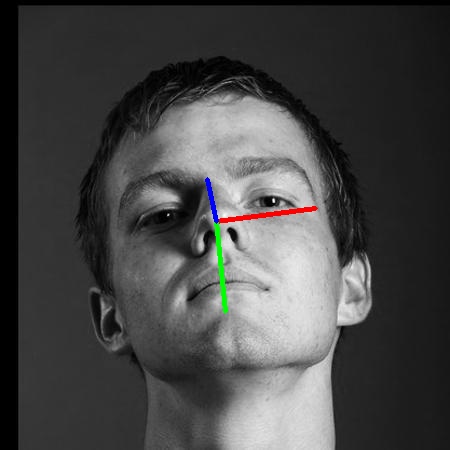

In [37]:
image = cv2.imread("/content/AFLW2000/image00854.jpg")
cv2_imshow(predict_image(image))


#Catch the video

In [38]:
def catch_videoo(videoo):
  arr=[]
  # create a VideoCapture object to read the video file
  cap = cv2.VideoCapture(videoo)
  # check if the video file was successfully opened
  if not cap.isOpened():
      print("Error: Could not open video file")
      exit()

  # loop over the frames in the video
  while True:
    try:
      
      ret, frame = cap.read()

      # check if the frame was successfully read
      if not ret:
          break
      # display the frame
      arr.append(frame)

      # wait for a key press to exit
      if cv2.waitKey(1) & 0xFF == ord('q'):
          break
    except:
      print('something wrong')
  # release the VideoCapture object and close all windows
  cap.release()
  return arr



In [39]:
arr = catch_videoo("/content/gdrive/MyDrive/20230221_062304.mp4")
len(arr)

525

#Make prediction for each frame in the video



In [40]:
def predict(videooo):
  faceModule = mp.solutions.face_mesh
  final_arr=[]
  with faceModule.FaceMesh(static_image_mode=True) as faces:
    for image in videooo:
      results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
      if results.multi_face_landmarks != None:
        final_arr.append(predict_image(image))   
  return final_arr

In [41]:
arrr1 = predict(arr)

#The Final video with the prediction

In [42]:
import cv2
import numpy as np
import os
# Define the dimensions of the video
width, height = 640, 480
fps = 20
# Create a VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*"mp4v") # Codec for the video
out = cv2.VideoWriter('output_12.mp4', fourcc, fps, (width, height))
# Loop over the image names and add them to the video
for image in arrr1:
    image = cv2.resize(image, (width, height)) # Resize the image to fit the video dimensions
    out.write(image)
# Release the video writer and close all windows
out.release()
cv2.destroyAllWindows()
